# Correlation Analysis Testing &  Troubleshooting

February 23 - March 2, 2022

The goal here is to replicate the correlation analysis from Cosyne 2021.

I have the following functions defined in `rnn-learning/utils/metric.py`

* `Fdata = flow_field_data(h_list,...)`
* `Fpred = flow_field_predicted(W,err_list,h_list)`
* `calculate_flow_field_correlation(Fpred,Fdata,h_list)`

Where `Fdata` and `Fpred` are simply matrices.

In the rest of this notebook, I would like to probe _what_ affects the correlation analysis:

* Change noise at the recurrent units `sig_rec`
* Change duration of the samples before, during and after training
* Compare RFLO, BPTT, and REINFORCE algorithms


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.bptt import BPTT
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation
from utils.functions import f, df

In [4]:
trial_duration = 20
n_in=4
frac_on = 0.4 # notice here the input duration - this usually makes the task easier

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

3it [00:00, 29.87it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 8
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: 0.5
sig_fb: 0.01
feedback_signal: position
velocity_transform: True
tau_vel: 2
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f91b76c8dc8>


500it [00:04, 100.66it/s]


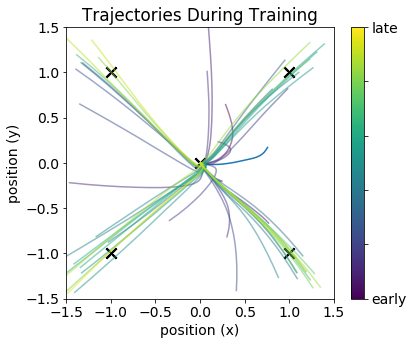

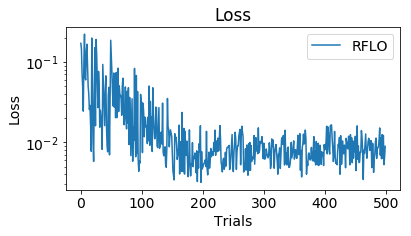

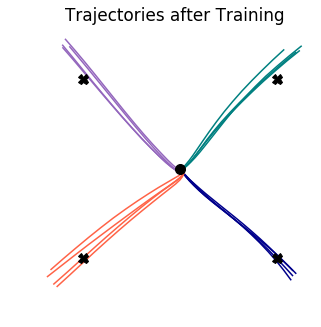

In [4]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=200,n_out=2,tau_rec=8,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
               sig_in=0.01,sig_rec=0.1,sig_out=0.01, sig_fb=0.01,
               velocity_transform=True, tau_vel = 2, dt_vel = 0.1,
               driving_feedback=False,
               rng=np.random.RandomState(1))
params.print_params()

# Initialize RNN
net0 = RNN(params,f=f,df=df)

# initialize simulation
sim0 = Simulation(net0)

rflo = RFLO(net0,apply_to=['w_rec']) 
sim0.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])


Good params for RFLO

```
params = RNNparams(n_in=4,n_rec=200,n_out=2,tau_rec=8,
                   eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
                   sig_in=0.0,sig_rec=0.2,sig_out=0.0, sig_fb=0.0,
                   velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
                   driving_feedback=False,
                   rng=np.random.RandomState(1))
```

Good parameters for REINFORCE

```
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
                   eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                   sig_in=0.01,sig_rec=0.5,sig_out=sig_out,
                   velocity_transform=False,
                   rng=np.random.RandomState(1))
```

# Experiment 1 - Different Internal Matrix RFLO

30it [00:00, 240.32it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f9194587d80>
corr coef:0.330


500it [00:00, 975.93it/s]
500it [00:00, 521.74it/s]
100it [00:00, 957.04it/s]


early fit 0.987, late fit 0.997


1000it [00:01, 735.53it/s]
60it [00:00, 597.84it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f91a16386c0>
corr coef:0.120


500it [00:00, 552.58it/s]
500it [00:02, 188.66it/s]
100it [00:00, 571.06it/s]


early fit 0.988, late fit 0.999


1000it [00:01, 832.22it/s]
55it [00:00, 544.84it/s]

n_in: 4
n_rec: 150
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f91b7c7ef78>
corr coef:0.094


500it [00:00, 715.38it/s]
500it [00:03, 154.44it/s]
100it [00:00, 530.89it/s]


early fit 0.987, late fit 0.999


1000it [00:01, 913.51it/s]
74it [00:00, 734.46it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f91b79b9fc0>
corr coef:0.147


500it [00:00, 829.71it/s]
500it [00:04, 117.31it/s]
100it [00:00, 782.48it/s]


early fit 0.990, late fit 0.998


1000it [00:01, 851.91it/s]
240it [00:00, 1141.67it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f91a186f2d0>
corr coef:0.028


500it [00:00, 1264.92it/s]
500it [00:00, 556.86it/s]
100it [00:00, 1287.65it/s]


early fit 0.987, late fit 0.998


1000it [00:00, 1356.98it/s]
92it [00:00, 915.59it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f91945b0240>
corr coef:0.110


500it [00:00, 995.13it/s]
500it [00:01, 283.55it/s]
100it [00:00, 999.11it/s]


early fit 0.987, late fit 0.999


1000it [00:00, 1031.64it/s]
75it [00:00, 748.36it/s]

n_in: 4
n_rec: 150
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f91b77c9ea0>
corr coef:0.190


500it [00:00, 873.99it/s]
500it [00:02, 198.49it/s]
100it [00:00, 870.04it/s]


early fit 0.988, late fit 0.997


1000it [00:01, 918.17it/s]
75it [00:00, 745.49it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f919471a288>
corr coef:0.193


500it [00:00, 835.11it/s]
500it [00:04, 113.49it/s]
100it [00:00, 764.34it/s]


early fit 0.990, late fit 0.997


1000it [00:01, 726.82it/s]
82it [00:00, 819.25it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f9191552288>
corr coef:0.352


500it [00:00, 1004.26it/s]
500it [00:01, 456.45it/s]
100it [00:00, 1234.06it/s]


early fit 0.987, late fit 0.996


1000it [00:00, 1121.54it/s]
71it [00:00, 704.69it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f91b7b462d0>
corr coef:0.236


500it [00:00, 816.32it/s]
500it [00:01, 259.00it/s]
100it [00:00, 948.76it/s]


early fit 0.987, late fit 0.998


1000it [00:01, 963.40it/s]
71it [00:00, 709.98it/s]

n_in: 4
n_rec: 150
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f9191e3d3a8>
corr coef:0.045


500it [00:00, 799.24it/s]
500it [00:04, 137.78it/s]
100it [00:00, 556.74it/s]


early fit 0.988, late fit 0.998


1000it [00:01, 859.17it/s]
141it [00:00, 698.22it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f9191c262d0>
corr coef:0.101


500it [00:00, 758.17it/s]
500it [00:04, 101.98it/s]
100it [00:00, 553.04it/s]


early fit 0.989, late fit 0.999


1000it [00:01, 736.74it/s]
119it [00:00, 1187.83it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f9191968318>
corr coef:0.178


500it [00:00, 1096.05it/s]
500it [00:01, 454.83it/s]
100it [00:00, 1092.78it/s]


early fit 0.986, late fit 0.998


1000it [00:00, 1210.22it/s]
48it [00:00, 477.49it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f9193b963a8>
corr coef:0.208


500it [00:00, 753.97it/s]
500it [00:02, 205.16it/s]
100it [00:00, 999.70it/s]


early fit 0.989, late fit 0.999


1000it [00:01, 507.37it/s]
63it [00:00, 624.23it/s]

n_in: 4
n_rec: 150
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f91b778fe58>
corr coef:0.155


500it [00:00, 647.08it/s]
500it [00:02, 180.70it/s]
100it [00:00, 781.98it/s]


early fit 0.990, late fit 0.999


1000it [00:02, 450.51it/s]
68it [00:00, 673.21it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f9193b50318>
corr coef:0.132


500it [00:00, 732.26it/s]
500it [00:05, 116.18it/s]
100it [00:00, 662.25it/s]


early fit 0.990, late fit 0.998


1000it [00:01, 814.66it/s]


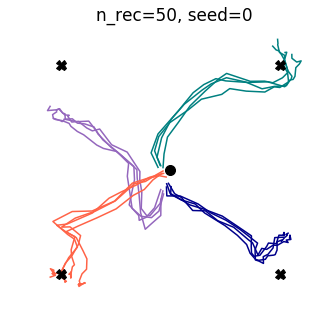

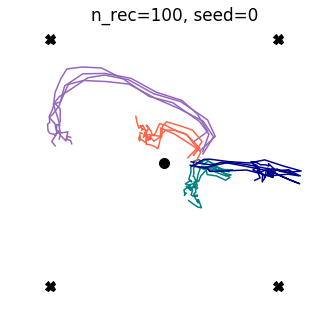

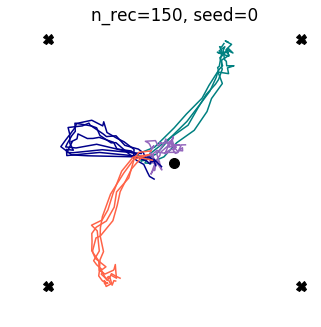

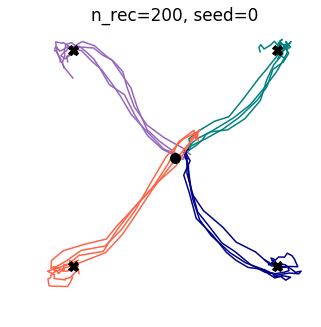

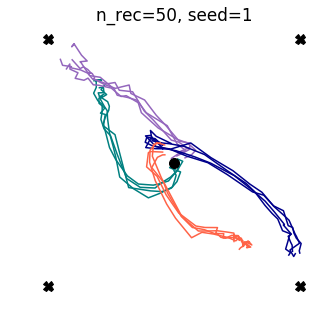

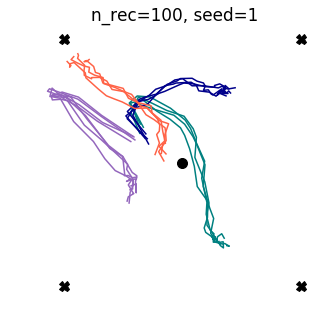

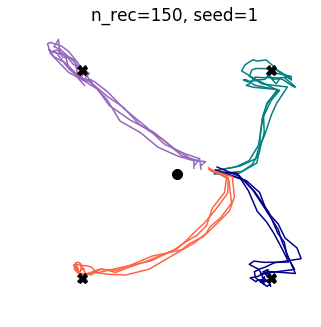

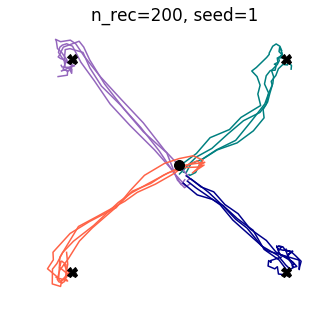

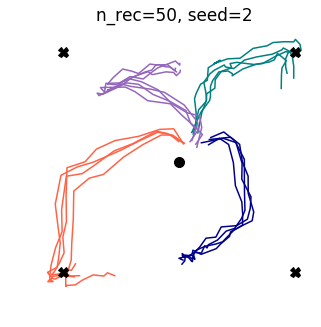

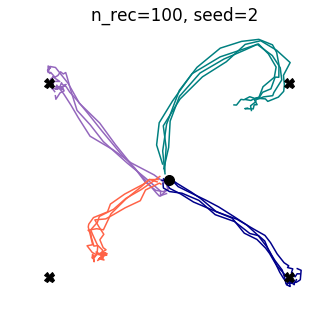

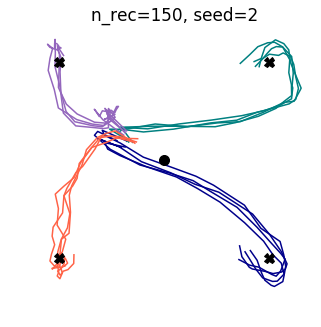

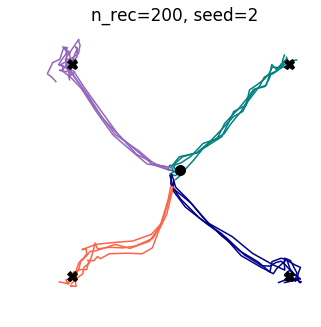

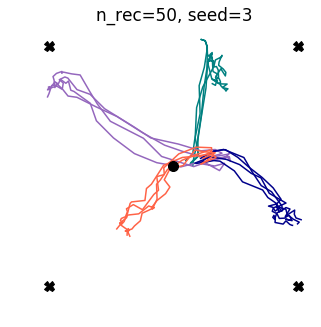

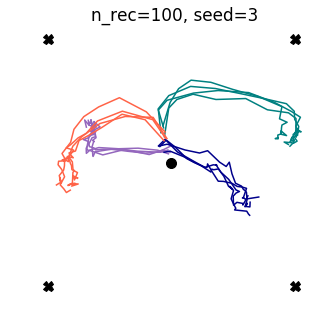

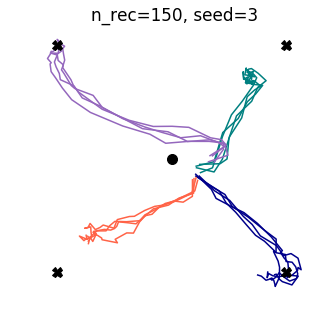

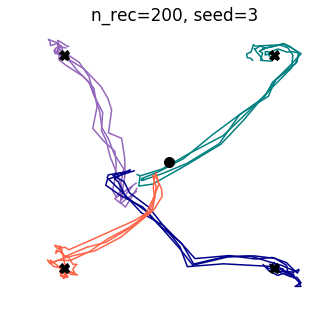

In [32]:
#noise = [0, 0.1,0.25,0.5, 1] #,1]

#noise = [0.01, 0.1,0.25,0.5]

sig_w_m=0.75
sig_rec = 0.1
sig_out=0.01
#noise = [0, 0.1,0.25,0.4,0.5,0.75, 1] 
neurons = [50,100,150,200]

""" Average over multiple seeds """
seeds = [0,1,2,3]

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corrcoef_list = []

    #for sig_out in noise:
    for n_rec in neurons:

        # Set RNN Parameters
        params = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=5,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                       sig_in=0.01,sig_rec=sig_rec,sig_out=sig_out,
                       velocity_transform=False,
                       rng=np.random.RandomState(seed))
        params.print_params()

        # Initialize RNN
        net0 = RNN(params)
        # set w_m matrix (with noise)
        w_m = np.copy(net0.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1]) # keep random value constant

        corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
        print('corr coef:{:.3f}'.format(corrcoef))
        corrcoef_list.append(corrcoef)
        net0.set_weights(w_m = w_m)

        # initialize simulation
        sim0 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim0.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)

        sim1 = Simulation(net0)
        """ RFLO """
        rflo = RFLO(net0,apply_to=['w_rec']) 
        sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=False, plot_freq=10)

    #     """ BPTT """
    #     bptt = BPTT(net0,apply_to=['w_rec']) # weight transport only applies when w_out is being learned
    #     sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

        """ REINFORCE """
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned
        #sim1.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=50)

        fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='n_rec={}, seed={}'.format(n_rec,seed))


        sim2 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim2.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)




        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim0.session_probes['h'])
        F_late, score_late = flow_field_data(sim2.session_probes['h'])

        print('early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        Fpred_w_out = flow_field_predicted(net0.w_out,sim1.session_probes['err'],sim1.session_probes['h'])
        Fpred_w_m = flow_field_predicted(net0.w_m.T,sim1.session_probes['err'],sim1.session_probes['h'])


        """ Test """
        # Should this be a different network?
    #     sim_test = Simulation(net0)
    #     trackvars = TrackVars(net0,apply_to=[]) 
    #     sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=True, plot_freq=10)

        """ Test """
        # Should this be a different network?
        # Set RNN Parameters
        params_test = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=8,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
                       sig_in=0.0,sig_rec=0.5,sig_out=0.1, sig_fb=0.0,
                       velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
                       driving_feedback=False,
                       rng=np.random.RandomState(seed+10)) # note different seed
        #params_test.print_params()

        # Initialize RNN to sample new points in neural activity space
        net_test = RNN(params_test)
        net_test.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_out=np.copy(net0.w_out),w_m=np.copy(net0.w_m))

        sim_test = Simulation(net_test)
        trackvars = TrackVars(net_test,apply_to=[]) 
        sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)


        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_m,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr2_list.append(corr2)
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corrcoef'].append(corrcoef_list)

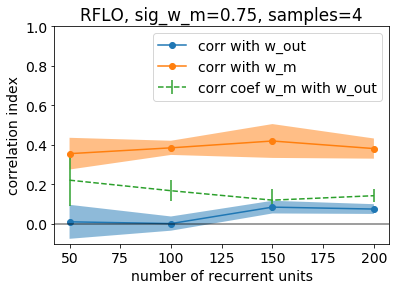

In [33]:
#plt.plot(noise,corr1_list,'o-',label='corr with w_out')
#plt.plot(noise,corr2_list,'o-',label='corr with w_m')
#plt.plot(noise,corrcoef_list,'x--',label='corr coef w_m with w_out')

""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)

plt.plot(neurons,mn1,'o-',label='corr with w_out')
plt.fill_between(neurons,mn1-std1,mn1+std1,alpha=0.5)
plt.plot(neurons,mn2,'o-',label='corr with w_m')
plt.fill_between(neurons,mn2-std2,mn2+std2,alpha=0.5)

# readout alignment
mn3 = np.mean(np.asarray(stats['corrcoef']),axis=0)
std3 = np.std(np.asarray(stats['corrcoef']),axis=0)
#plt.plot(neurons,mn3,'x--',label='corr coef w_m with w_out')
plt.errorbar(neurons,mn3,yerr=std3,label='corr coef w_m with w_out',linestyle='--')

plt.axhline(0,color='k',alpha=0.5)

#plt.xlabel('sig_rec')
#plt.xlabel('sig_out')
#plt.xlabel('sig_w_m')
plt.xlabel('number of recurrent units')
plt.ylabel('correlation index')
plt.ylim([-0.1,1])
plt.title('RFLO, sig_w_m={:.2f}, samples={}'.format(sig_w_m,len(stats['corr1'])))
plt.legend()
plt.show()

# Experiment 1B - Different Internal Matrix RFLO, vary recurrent noise

In [ ]:
#noise = [0, 0.1,0.25,0.5, 1] #,1]

#noise = [0.01, 0.1,0.25,0.5]

sig_w_m=0.5
sig_rec = 0.1
sig_out=0.01
noise = [0, 0.1,0.25,0.5,0.75, 1] 
#neurons = [50,100,150,200]
n_rec = 100

""" Average over multiple seeds """
seeds = [0,1,2,3]

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corrcoef_list = []

    #for sig_out in noise:
    for sig_rec in noise:

        # Set RNN Parameters
        params = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=5,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                       sig_in=0.01,sig_rec=sig_rec,sig_out=sig_out,
                       velocity_transform=False,
                       rng=np.random.RandomState(seed))
        params.print_params()

        # Initialize RNN
        net0 = RNN(params)
        # set w_m matrix (with noise)
        w_m = np.copy(net0.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1])  # << keep random value constant, SHOULD NORMALIZE HERE

        corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
        print('corr coef:{:.3f}'.format(corrcoef))
        corrcoef_list.append(corrcoef)
        net0.set_weights(w_m = w_m)

        # initialize simulation
        sim0 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim0.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)

        sim1 = Simulation(net0)
        """ RFLO """
        rflo = RFLO(net0,apply_to=['w_rec']) 
        sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=False, plot_freq=10)

    #     """ BPTT """
    #     bptt = BPTT(net0,apply_to=['w_rec']) # weight transport only applies when w_out is being learned
    #     sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

        """ REINFORCE """
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned
        #sim1.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=50)

        fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='sig_rec={:.2f}, seed={}'.format(sig_rec,seed))


        sim2 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim2.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)




        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim0.session_probes['h'])
        F_late, score_late = flow_field_data(sim2.session_probes['h'])

        print('early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        Fpred_w_out = flow_field_predicted(net0.w_out,sim1.session_probes['err'],sim1.session_probes['h'])
        Fpred_w_m = flow_field_predicted(net0.w_m.T,sim1.session_probes['err'],sim1.session_probes['h'])


        """ Test """
        # Should this be a different network?
    #     sim_test = Simulation(net0)
    #     trackvars = TrackVars(net0,apply_to=[]) 
    #     sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=True, plot_freq=10)

        """ Test """
        # Should this be a different network?
        # Set RNN Parameters
        params_test = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=8,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
                       sig_in=0.0,sig_rec=0.5,sig_out=0.1, sig_fb=0.0,
                       velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
                       driving_feedback=False,
                       rng=np.random.RandomState(seed+10)) # note different seed
        #params_test.print_params()

        # Initialize RNN to sample new points in neural activity space
        net_test = RNN(params_test)
        net_test.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_out=np.copy(net0.w_out),w_m=np.copy(net0.w_m))

        sim_test = Simulation(net_test)
        trackvars = TrackVars(net_test,apply_to=[]) 
        sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)


        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_m,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr2_list.append(corr2)
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corrcoef'].append(corrcoef_list)

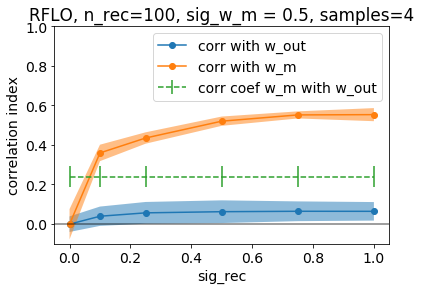

In [36]:


""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)

plt.plot(noise,mn1,'o-',label='corr with w_out')
plt.fill_between(noise,mn1-std1,mn1+std1,alpha=0.5)
plt.plot(noise,mn2,'o-',label='corr with w_m')
plt.fill_between(noise,mn2-std2,mn2+std2,alpha=0.5)

# readout alignment
mn3 = np.mean(np.asarray(stats['corrcoef']),axis=0)
std3 = np.std(np.asarray(stats['corrcoef']),axis=0)
#plt.plot(neurons,mn3,'x--',label='corr coef w_m with w_out')
plt.errorbar(noise,mn3,yerr=std3,label='corr coef w_m with w_out',linestyle='--')

plt.axhline(0,color='k',alpha=0.5)

plt.xlabel('sig_rec')
#plt.xlabel('sig_out')
#plt.xlabel('sig_w_m')
#plt.xlabel('number of recurrent units')
plt.ylabel('correlation index')
plt.ylim([-0.1,1])
plt.title('RFLO, n_rec={}, sig_w_m = {}, samples={}'.format(n_rec,sig_w_m,len(stats['corr1'])))
plt.legend()
plt.show()

# Experiment 1C - Vary overlap

In [ ]:
#noise = [0, 0.1,0.25,0.5, 1] #,1]

#noise = [0.01, 0.1,0.25,0.5]

sig_w_m=0.5
sig_rec = 0.1
sig_out=0.01
noise = [0, 0.1,0.25,0.5,0.75, 1] 
#neurons = [50,100,150,200]
n_rec = 100

""" Average over multiple seeds """
seeds = [0,1,2,3]

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corrcoef_list = []

    #for sig_out in noise:
    for sig_w_m in noise:

        # Set RNN Parameters
        params = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=5,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                       sig_in=0.01,sig_rec=sig_rec,sig_out=sig_out,
                       velocity_transform=False,
                       rng=np.random.RandomState(seed))
        params.print_params()

        # Initialize RNN
        net0 = RNN(params)
        # set w_m matrix (with noise)
        w_m = np.copy(net0.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1])  # << keep random value constant, SHOULD NORMALIZE HERE

        corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
        print('corr coef:{:.3f}'.format(corrcoef))
        corrcoef_list.append(corrcoef)
        net0.set_weights(w_m = w_m)

        # initialize simulation
        sim0 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim0.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)

        sim1 = Simulation(net0)
        """ RFLO """
        rflo = RFLO(net0,apply_to=['w_rec']) 
        sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=False, plot_freq=10)

    #     """ BPTT """
    #     bptt = BPTT(net0,apply_to=['w_rec']) # weight transport only applies when w_out is being learned
    #     sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

        """ REINFORCE """
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned
        #sim1.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=50)

        fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='sig_rec={:.2f}, sig_w_m={:.2f}, seed={}'.format(sig_rec,sig_w_m,seed))


        sim2 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim2.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)




        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim0.session_probes['h'])
        F_late, score_late = flow_field_data(sim2.session_probes['h'])

        print('early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_earlyc

        Fpred_w_out = flow_field_predicted(net0.w_out,sim1.session_probes['err'],sim1.session_probes['h'])
        Fpred_w_m = flow_field_predicted(net0.w_m.T,sim1.session_probes['err'],sim1.session_probes['h'])


        """ Test """
        # Should this be a different network?
    #     sim_test = Simulation(net0)
    #     trackvars = TrackVars(net0,apply_to=[]) 
    #     sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=True, plot_freq=10)

        """ Test """
        # Should this be a different network?
        # Set RNN Parameters
        params_test = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=8,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
                       sig_in=0.0,sig_rec=0.5,sig_out=0.1, sig_fb=0.0,
                       velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
                       driving_feedback=False,
                       rng=np.random.RandomState(seed+10)) # note different seed
        #params_test.print_params()

        # Initialize RNN to sample new points in neural activity space
        net_test = RNN(params_test)
        net_test.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_out=np.copy(net0.w_out),w_m=np.copy(net0.w_m))

        sim_test = Simulation(net_test)
        trackvars = TrackVars(net_test,apply_to=[]) 
        sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)


        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_m,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr2_list.append(corr2)
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corrcoef'].append(corrcoef_list)

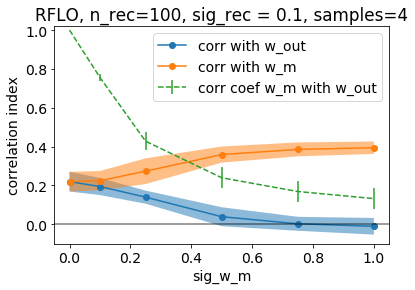

In [45]:
""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)

plt.plot(noise,mn1,'o-',label='corr with w_out')
plt.fill_between(noise,mn1-std1,mn1+std1,alpha=0.5)
plt.plot(noise,mn2,'o-',label='corr with w_m')
plt.fill_between(noise,mn2-std2,mn2+std2,alpha=0.5)

# readout alignment
mn3 = np.mean(np.asarray(stats['corrcoef']),axis=0)
std3 = np.std(np.asarray(stats['corrcoef']),axis=0)
#plt.plot(neurons,mn3,'x--',label='corr coef w_m with w_out')
plt.errorbar(noise,mn3,yerr=std3,label='corr coef w_m with w_out',linestyle='--')

plt.axhline(0,color='k',alpha=0.5)

#plt.xlabel('sig_rec')
#plt.xlabel('sig_out')
plt.xlabel('sig_w_m')
#plt.xlabel('number of recurrent units')
plt.ylabel('correlation index')
plt.ylim([-0.1,1.02])
plt.title('RFLO, n_rec={}, sig_rec = {}, samples={}'.format(n_rec,sig_rec,len(stats['corr1'])))
plt.legend()
plt.show()

# Experiment 1D - Vary overlap + W_fb

In [ ]:
#noise = [0, 0.1,0.25,0.5, 1] #,1]

#noise = [0.01, 0.1,0.25,0.5]
trials0=500
trials1=5000
trials2=500
trials3=1000

sig_w_m=0.5
sig_rec = 0.1
sig_out=0.01
noise = [0, 0.1,0.25,0.5] #,0.75, 1] 
#neurons = [50,100,150,200]
n_rec = 100

""" Average over multiple seeds """
seeds = [0,1] #,2,3]

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corrcoef_list = []

    #for sig_out in noise:
    for sig_w_m in noise:

        # Set RNN Parameters
        params = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=5,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1, eta_fb = 0.1,
                       sig_in=0.01,sig_rec=sig_rec,sig_out=sig_out, sig_fb=0,
                       velocity_transform=False,
                       driving_feedback=True,
                       rng=np.random.RandomState(seed))
        params.print_params()

        # Initialize RNN
        net0 = RNN(params)
        # set w_m matrix (with noise)
        w_m = np.copy(net0.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1])  # << keep random value constant, SHOULD NORMALIZE HERE

        corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
        print('corr coef:{:.3f}'.format(corrcoef))
        corrcoef_list.append(corrcoef)
        net0.set_weights(w_m = w_m)

        # initialize simulation
        sim0 = Simulation(net0)
        
        rflo = RFLO(net0,apply_to=['w_rec']) 
        print('\n>>LEARNING IN W_rec for 100 trials')
        sim0.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim0.run_session(n_trials=trials0, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)

        sim1 = Simulation(net0)
        """ RFLO """
        
        rflo = RFLO(net0,apply_to=['w_fb']) 
        print('\n>>LEARNING IN W_FB')
        sim1.run_session(n_trials=trials1, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

    #     """ BPTT """
    #     bptt = BPTT(net0,apply_to=['w_rec']) # weight transport only applies when w_out is being learned
    #     sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

        """ REINFORCE """
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned
        #sim1.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=50)

        fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='sig_rec={:.2f}, sig_w_m={:.2f}, seed={}'.format(sig_rec,sig_w_m,seed))


        sim2 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim2.run_session(n_trials=trials2, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)




        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim0.session_probes['h'])
        F_late, score_late = flow_field_data(sim2.session_probes['h'])

        print('early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        Fpred_w_out = flow_field_predicted(net0.w_out,sim1.session_probes['err'],sim1.session_probes['h'])
        Fpred_w_m = flow_field_predicted(net0.w_m.T,sim1.session_probes['err'],sim1.session_probes['h'])


        """ Test """
        # Should this be a different network?
    #     sim_test = Simulation(net0)
    #     trackvars = TrackVars(net0,apply_to=[]) 
    #     sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=True, plot_freq=10)

        """ Test """
        # Should this be a different network?
        # Set RNN Parameters
        params_test = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=8,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
                       sig_in=0.0,sig_rec=0.5,sig_out=0.1, sig_fb=0.0,
                       velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
                       driving_feedback=False,
                       rng=np.random.RandomState(seed+10)) # note different seed
        #params_test.print_params()

        # Initialize RNN to sample new points in neural activity space
        net_test = RNN(params_test)
        net_test.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_out=np.copy(net0.w_out),w_m=np.copy(net0.w_m))

        sim_test = Simulation(net_test)
        trackvars = TrackVars(net_test,apply_to=[]) 
        sim_test.run_session(n_trials=trials3, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)


        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_m,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr2_list.append(corr2)
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corrcoef'].append(corrcoef_list)

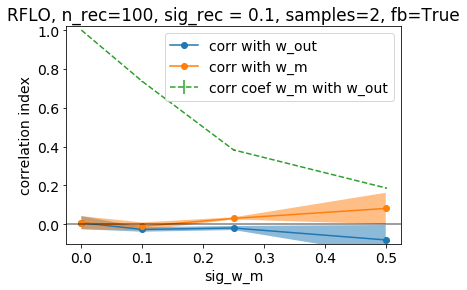

In [63]:
""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)

plt.plot(noise,mn1,'o-',label='corr with w_out')
plt.fill_between(noise,mn1-std1,mn1+std1,alpha=0.5)
plt.plot(noise,mn2,'o-',label='corr with w_m')
plt.fill_between(noise,mn2-std2,mn2+std2,alpha=0.5)

# readout alignment
mn3 = np.mean(np.asarray(stats['corrcoef']),axis=0)
std3 = np.std(np.asarray(stats['corrcoef']),axis=0)
#plt.plot(neurons,mn3,'x--',label='corr coef w_m with w_out')
plt.errorbar(noise,mn3,yerr=std3,label='corr coef w_m with w_out',linestyle='--')

plt.axhline(0,color='k',alpha=0.5)

#plt.xlabel('sig_rec')
#plt.xlabel('sig_out')
plt.xlabel('sig_w_m')
#plt.xlabel('number of recurrent units')
plt.ylabel('correlation index')
plt.ylim([-0.1,1.02])
plt.title('RFLO, n_rec={}, sig_rec = {}, samples={}, fb={}'.format(n_rec,sig_rec,len(stats['corr1']),net0.driving_feedback))
plt.legend()
plt.show()

# Experiment 1E - Velocity Transform

42it [00:00, 414.16it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f91881a1d80>
corr coef:1.000


500it [00:00, 671.34it/s]
1000it [00:04, 232.42it/s]
500it [00:00, 886.32it/s]


early fit 0.988, late fit 0.991


1000it [00:01, 932.22it/s]
157it [00:00, 701.67it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f918e7f3d80>
corr coef:0.739


500it [00:00, 750.06it/s]
1000it [00:03, 275.88it/s]
500it [00:00, 512.03it/s]


early fit 0.988, late fit 0.994


1000it [00:01, 607.36it/s]
35it [00:00, 344.53it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f91874d4cf0>
corr coef:0.388


500it [00:01, 451.33it/s]
1000it [00:03, 271.69it/s]
500it [00:00, 637.95it/s]


early fit 0.988, late fit 0.997


1000it [00:01, 776.55it/s]
50it [00:00, 489.95it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f9189b4d090>
corr coef:0.193


500it [00:00, 610.48it/s]
1000it [00:03, 262.24it/s]
500it [00:00, 628.18it/s]


early fit 0.988, late fit 0.998


1000it [00:01, 727.51it/s]
47it [00:00, 468.57it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f9189b4d2d0>
corr coef:0.120


500it [00:00, 603.60it/s]
1000it [00:03, 254.98it/s]
500it [00:00, 693.06it/s]


early fit 0.988, late fit 0.999


1000it [00:01, 733.45it/s]
102it [00:00, 491.09it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f918bda3ab0>
corr coef:0.083


500it [00:00, 631.63it/s]
1000it [00:03, 260.78it/s]
500it [00:00, 658.12it/s]


early fit 0.988, late fit 0.999


1000it [00:01, 916.26it/s]
68it [00:00, 675.19it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f918b9baa20>
corr coef:1.000


500it [00:00, 758.44it/s]
1000it [00:03, 259.83it/s]
500it [00:00, 801.01it/s]


early fit 0.987, late fit 0.991


1000it [00:01, 906.51it/s]
45it [00:00, 448.30it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f9188481a20>
corr coef:0.733


500it [00:00, 748.66it/s]
1000it [00:03, 252.07it/s]
500it [00:00, 534.32it/s]


early fit 0.987, late fit 0.993


1000it [00:01, 650.06it/s]
38it [00:00, 377.86it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f9186953120>
corr coef:0.378


500it [00:00, 510.20it/s]
1000it [00:04, 216.59it/s]
500it [00:00, 825.23it/s]


early fit 0.987, late fit 0.997


1000it [00:01, 830.20it/s]
83it [00:00, 825.07it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f91874429d8>
corr coef:0.182


500it [00:00, 775.15it/s]
1000it [00:03, 251.34it/s]
500it [00:00, 893.28it/s]


early fit 0.987, late fit 0.999


1000it [00:01, 972.30it/s]
60it [00:00, 596.75it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f918738fa68>
corr coef:0.110


500it [00:00, 815.51it/s]
1000it [00:04, 242.66it/s]
500it [00:02, 219.78it/s]


early fit 0.987, late fit 0.999


1000it [00:03, 259.15it/s]
19it [00:00, 179.36it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f91718959d8>
corr coef:0.073


500it [00:01, 433.94it/s]
1000it [00:05, 181.67it/s]
500it [00:00, 573.28it/s]


early fit 0.987, late fit 0.999


1000it [00:01, 537.16it/s]
59it [00:00, 585.25it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f91718dc990>
corr coef:1.000


500it [00:01, 453.48it/s]
1000it [00:04, 215.92it/s]
500it [00:00, 788.46it/s]


early fit 0.987, late fit 0.992


1000it [00:01, 911.21it/s]
75it [00:00, 742.49it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f91721579d8>
corr coef:0.780


500it [00:00, 759.97it/s]
1000it [00:04, 225.38it/s]
500it [00:00, 724.07it/s]


early fit 0.987, late fit 0.993


1000it [00:01, 619.30it/s]
76it [00:00, 757.10it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f91721b3948>
corr coef:0.483


500it [00:00, 764.88it/s]
1000it [00:04, 241.67it/s]
500it [00:00, 523.13it/s]


early fit 0.987, late fit 0.995


1000it [00:01, 513.12it/s]
38it [00:00, 379.91it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f919c6a9510>
corr coef:0.305


500it [00:00, 522.56it/s]
1000it [00:05, 190.54it/s]
500it [00:00, 633.66it/s]


early fit 0.987, late fit 0.997


1000it [00:01, 671.94it/s]
74it [00:00, 374.39it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f9171948948>
corr coef:0.236


500it [00:02, 202.38it/s]
1000it [00:05, 178.21it/s]
500it [00:01, 441.79it/s]


early fit 0.987, late fit 0.998


1000it [00:02, 487.52it/s]
43it [00:00, 426.47it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7f9171965948>
corr coef:0.200


500it [00:01, 401.20it/s]
1000it [00:05, 191.40it/s]
500it [00:01, 491.98it/s]


early fit 0.987, late fit 0.998


1000it [00:01, 637.40it/s]


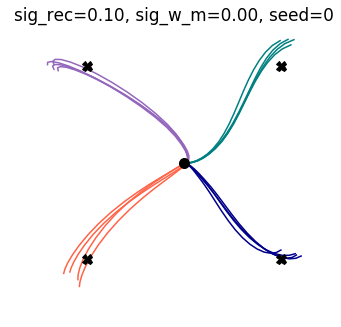

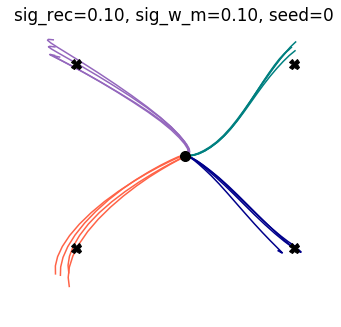

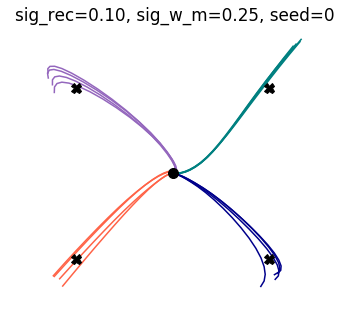

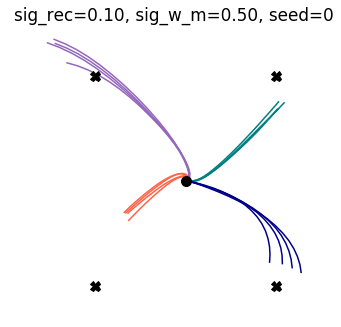

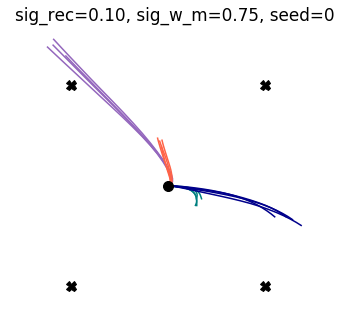

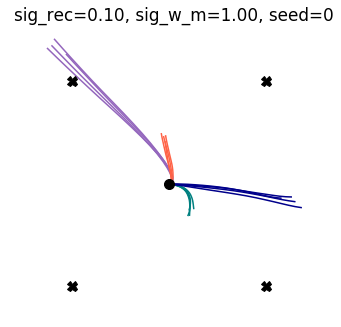

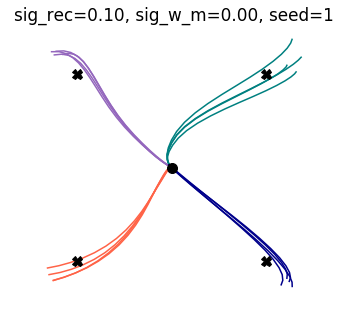

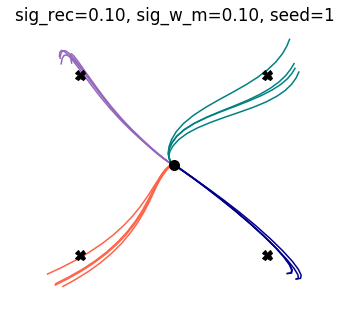

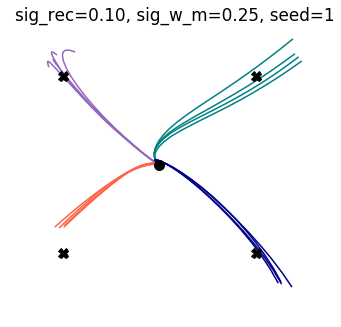

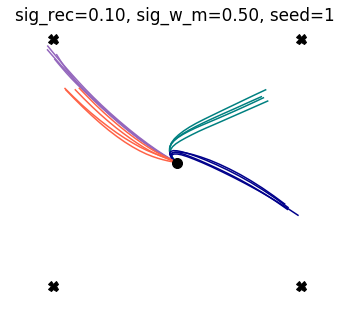

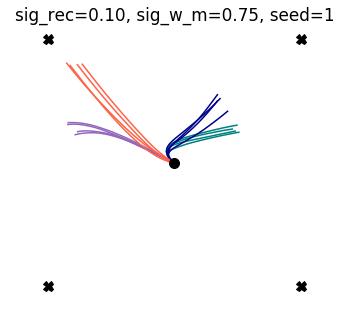

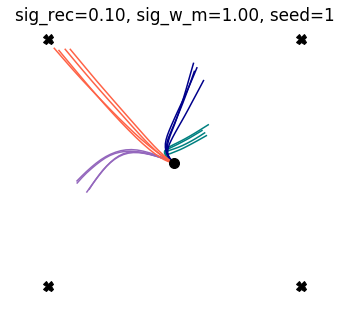

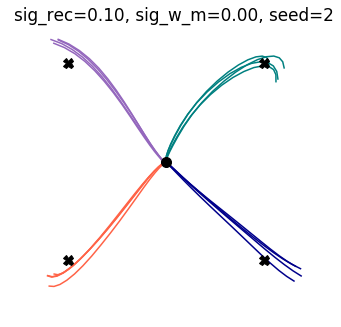

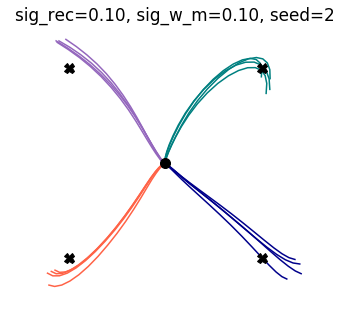

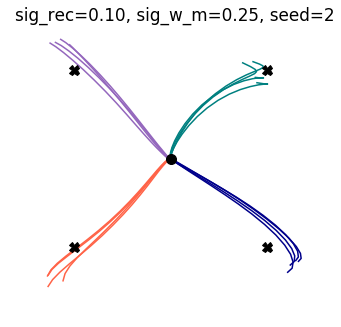

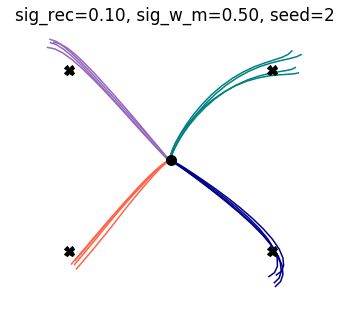

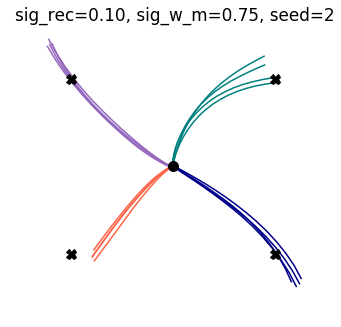

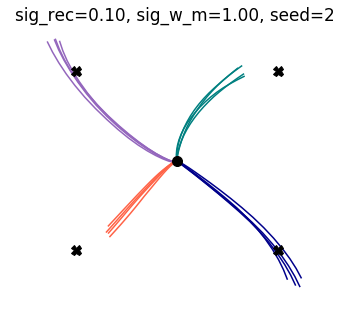

In [66]:
#noise = [0, 0.1,0.25,0.5, 1] #,1]

#noise = [0.01, 0.1,0.25,0.5]
trials0=500
trials1=1000
trials2=500
trials3=1000

sig_w_m=0.5
sig_rec = 0.1
sig_out=0.01
noise = [0, 0.1,0.25,0.5,0.75, 1] 
#neurons = [50,100,150,200]
n_rec = 100

""" Average over multiple seeds """
seeds = [0,1,2]#,3]

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corrcoef_list = []

    #for sig_out in noise:
    for sig_w_m in noise:

        # Set RNN Parameters
        params = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=5,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                       sig_in=0.01,sig_rec=sig_rec,sig_out=sig_out,
                       velocity_transform=True, tau_vel = 5, dt_vel = 0.1,
                       rng=np.random.RandomState(seed))
        params.print_params()

        # Initialize RNN
        net0 = RNN(params)
        # set w_m matrix (with noise)
        w_m = np.copy(net0.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1])  # << keep random value constant, SHOULD NORMALIZE HERE

        corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
        print('corr coef:{:.3f}'.format(corrcoef))
        corrcoef_list.append(corrcoef)
        net0.set_weights(w_m = w_m)

        # initialize simulation
        sim0 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim0.run_session(n_trials=trials0, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)

        sim1 = Simulation(net0)
        """ RFLO """
        rflo = RFLO(net0,apply_to=['w_rec']) 
        sim1.run_session(n_trials=trials1, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=False, plot_freq=10)

    #     """ BPTT """
    #     bptt = BPTT(net0,apply_to=['w_rec']) # weight transport only applies when w_out is being learned
    #     sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

        """ REINFORCE """
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned
        #sim1.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=50)

        fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='sig_rec={:.2f}, sig_w_m={:.2f}, seed={}'.format(sig_rec,sig_w_m,seed))


        sim2 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim2.run_session(n_trials=trials2, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)




        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim0.session_probes['h'])
        F_late, score_late = flow_field_data(sim2.session_probes['h'])

        print('early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        Fpred_w_out = flow_field_predicted(net0.w_out,sim1.session_probes['err'],sim1.session_probes['h'])
        Fpred_w_m = flow_field_predicted(net0.w_m.T,sim1.session_probes['err'],sim1.session_probes['h'])


        """ Test """
        # Should this be a different network?
    #     sim_test = Simulation(net0)
    #     trackvars = TrackVars(net0,apply_to=[]) 
    #     sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=True, plot_freq=10)

        """ Test """
        # Should this be a different network?
        # Set RNN Parameters
        params_test = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=8,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
                       sig_in=0.0,sig_rec=0.5,sig_out=0.1, sig_fb=0.0,
                       velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
                       driving_feedback=False,
                       rng=np.random.RandomState(seed+10)) # note different seed
        #params_test.print_params()

        # Initialize RNN to sample new points in neural activity space
        net_test = RNN(params_test)
        net_test.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_out=np.copy(net0.w_out),w_m=np.copy(net0.w_m))

        sim_test = Simulation(net_test)
        trackvars = TrackVars(net_test,apply_to=[]) 
        sim_test.run_session(n_trials=trials3, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)


        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_m,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr2_list.append(corr2)
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corrcoef'].append(corrcoef_list)

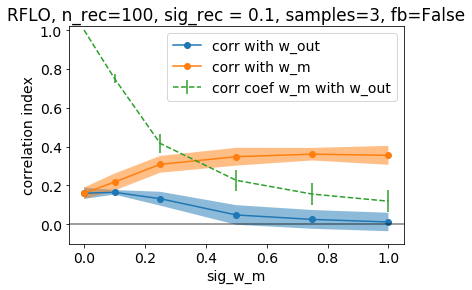

In [67]:
""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)

plt.plot(noise,mn1,'o-',label='corr with w_out')
plt.fill_between(noise,mn1-std1,mn1+std1,alpha=0.5)
plt.plot(noise,mn2,'o-',label='corr with w_m')
plt.fill_between(noise,mn2-std2,mn2+std2,alpha=0.5)

# readout alignment
mn3 = np.mean(np.asarray(stats['corrcoef']),axis=0)
std3 = np.std(np.asarray(stats['corrcoef']),axis=0)
#plt.plot(neurons,mn3,'x--',label='corr coef w_m with w_out')
plt.errorbar(noise,mn3,yerr=std3,label='corr coef w_m with w_out',linestyle='--')

plt.axhline(0,color='k',alpha=0.5)

#plt.xlabel('sig_rec')
#plt.xlabel('sig_out')
plt.xlabel('sig_w_m')
#plt.xlabel('number of recurrent units')
plt.ylabel('correlation index')
plt.ylim([-0.1,1.02])
plt.title('RFLO, n_rec={}, sig_rec = {}, samples={}, fb={}'.format(n_rec,sig_rec,len(stats['corr1']),net0.driving_feedback))
plt.legend()
plt.show()

# Experiment 2A - Different Internal Matrix REINFORCE

77it [00:00, 766.16it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.25
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4d3bbce10>
corr coef:0.614


500it [00:00, 1031.18it/s]
5000it [00:11, 439.87it/s]
500it [00:00, 1181.27it/s]


early fit 0.962, late fit 0.975


1000it [00:01, 995.91it/s]
29it [00:00, 281.71it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.5
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4d0223ee8>
corr coef:0.614


500it [00:00, 865.27it/s]
5000it [00:11, 424.06it/s]
500it [00:00, 1343.59it/s]


early fit 0.909, late fit 0.945


1000it [00:00, 1400.41it/s]
258it [00:00, 1233.31it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.75
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4d2c20fc0>
corr coef:0.614


500it [00:00, 1323.78it/s]
5000it [00:09, 547.09it/s]
500it [00:00, 1378.82it/s]


early fit 0.857, late fit 0.906


1000it [00:00, 1347.70it/s]
117it [00:00, 1165.78it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4d1f6cf30>
corr coef:0.614


500it [00:00, 1287.30it/s]
5000it [00:09, 555.01it/s]
500it [00:00, 1324.32it/s]


early fit 0.816, late fit 0.875


1000it [00:00, 1376.56it/s]
122it [00:00, 1217.90it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.25
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4d2c20b40>
corr coef:0.414


500it [00:00, 1324.63it/s]
5000it [00:09, 524.21it/s]
500it [00:00, 1398.96it/s]


early fit 0.961, late fit 0.973


1000it [00:00, 1387.19it/s]
120it [00:00, 1196.70it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.5
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4d1f6c750>
corr coef:0.414


500it [00:00, 1340.27it/s]
5000it [00:10, 471.99it/s]
500it [00:00, 1278.63it/s]


early fit 0.908, late fit 0.945


1000it [00:00, 1162.56it/s]
94it [00:00, 934.03it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.75
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4d4556cf0>
corr coef:0.414


500it [00:00, 1175.54it/s]
5000it [00:11, 424.53it/s]
/Users/jacobportes/anaconda3/envs/pt/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
500it [00:00, 1203.38it/s]


early fit 0.857, late fit 0.912


1000it [00:00, 1326.66it/s]
117it [00:00, 1160.69it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4d44addc8>
corr coef:0.414


500it [00:00, 1250.83it/s]
/Users/jacobportes/anaconda3/envs/pt/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
5000it [00:15, 332.14it/s]
500it [00:00, 738.40it/s]


early fit 0.817, late fit 0.860


1000it [00:00, 1340.43it/s]
255it [00:00, 1225.88it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.25
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4d41a1048>
corr coef:0.632


500it [00:00, 1291.11it/s]
/Users/jacobportes/anaconda3/envs/pt/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
5000it [00:14, 342.13it/s]
500it [00:02, 195.08it/s]


early fit 0.964, late fit 0.971


1000it [00:01, 768.48it/s]
27it [00:00, 268.80it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.5
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4de1de3f0>
corr coef:0.632


500it [00:00, 590.00it/s]
/Users/jacobportes/anaconda3/envs/pt/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
5000it [00:14, 337.94it/s]
500it [00:00, 601.18it/s]


early fit 0.912, late fit 0.939


1000it [00:01, 512.60it/s]
25it [00:00, 247.75it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.75
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4e5ef9e58>
corr coef:0.632


500it [00:00, 576.92it/s]
/Users/jacobportes/anaconda3/envs/pt/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
5000it [00:14, 334.05it/s]
500it [00:00, 942.71it/s]


early fit 0.861, late fit 0.919


1000it [00:01, 862.35it/s]
46it [00:00, 454.30it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7fe4dbc27870>
corr coef:0.632


500it [00:00, 625.91it/s]
/Users/jacobportes/anaconda3/envs/pt/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
5000it [00:18, 276.82it/s]
500it [00:00, 637.10it/s]


early fit 0.820, late fit 0.879


1000it [00:01, 629.82it/s]


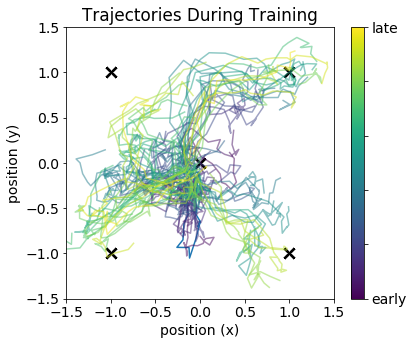

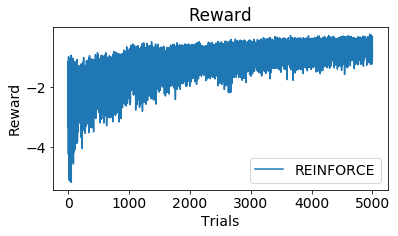

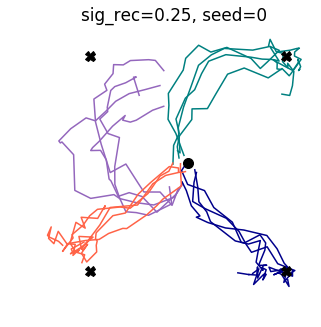

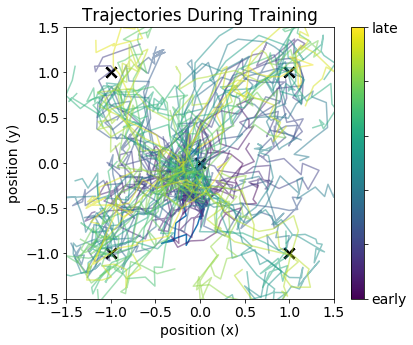

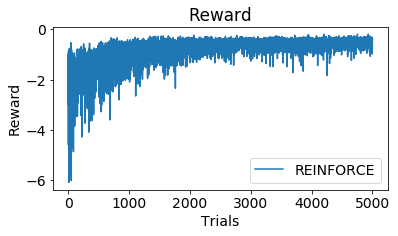

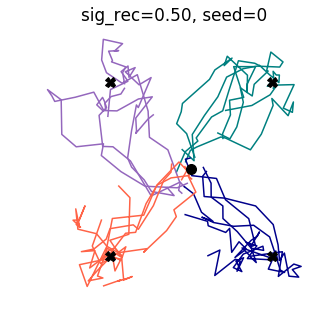

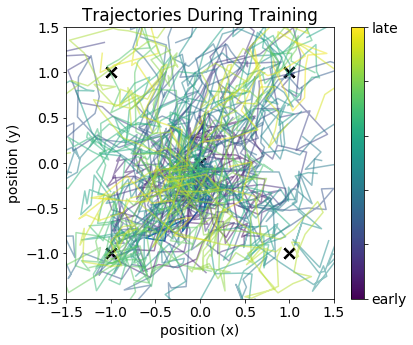

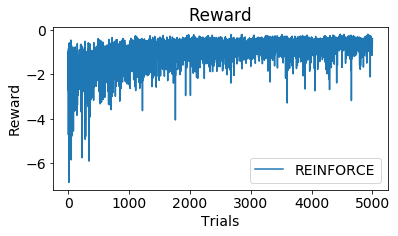

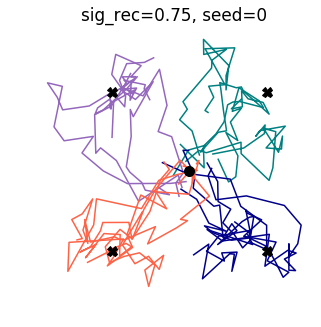

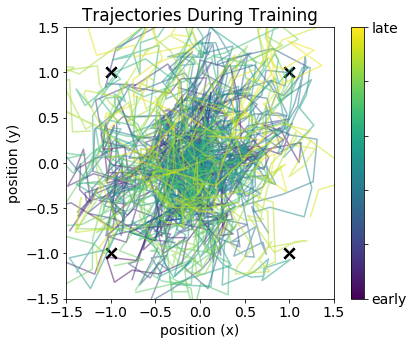

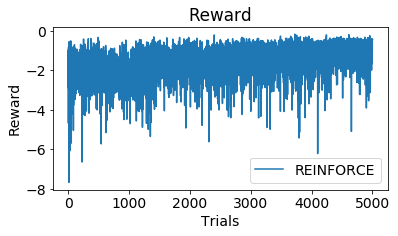

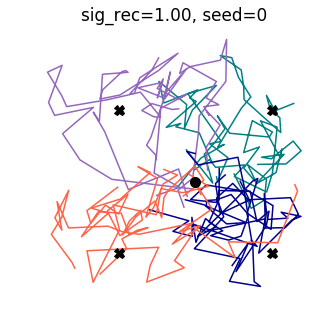

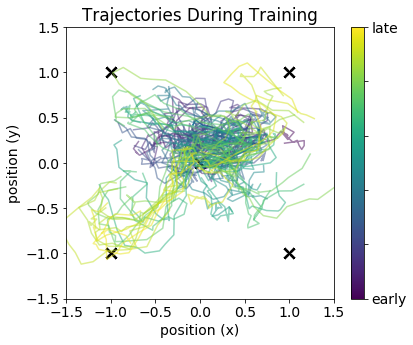

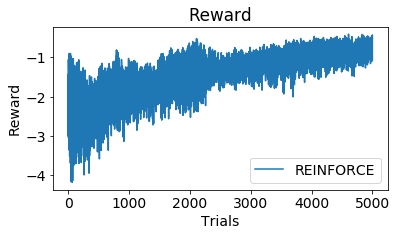

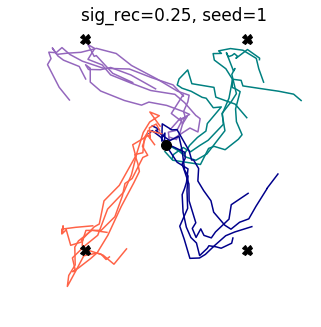

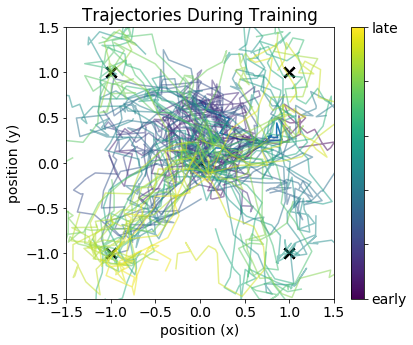

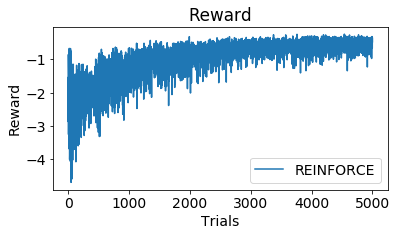

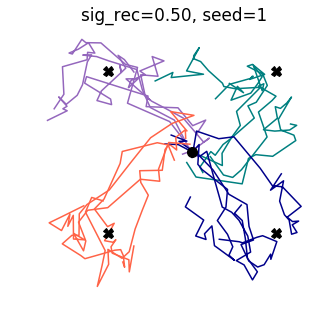

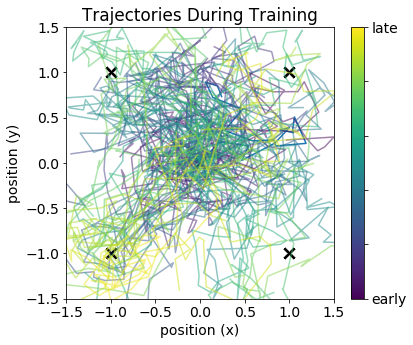

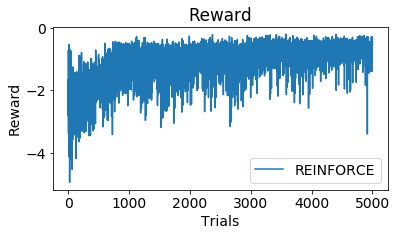

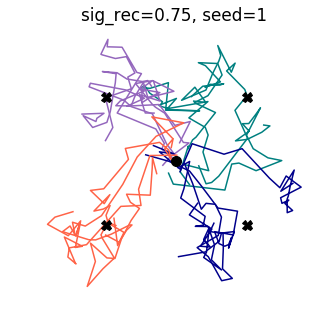

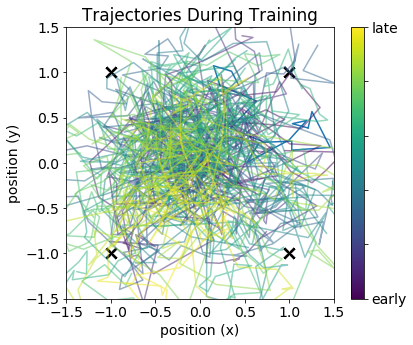

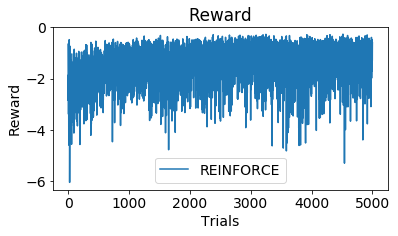

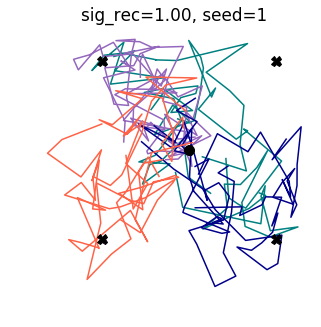

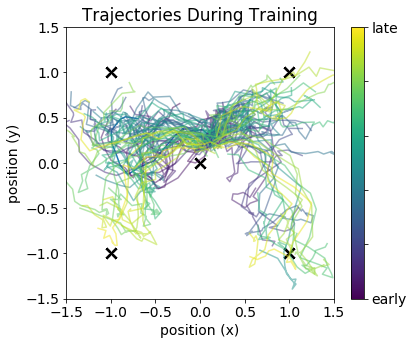

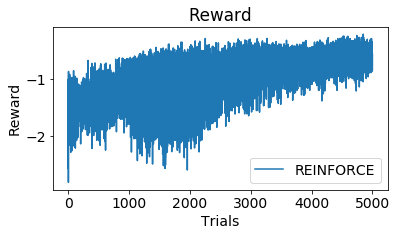

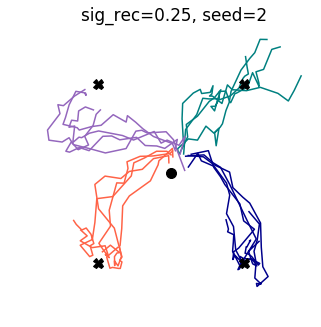

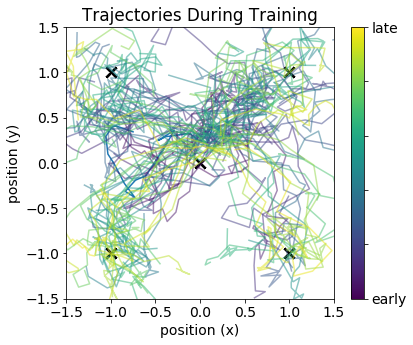

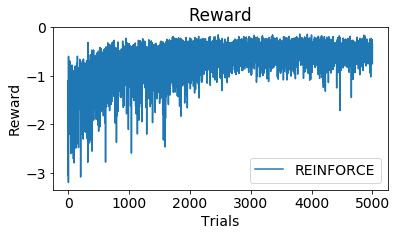

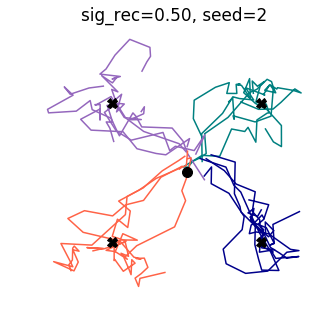

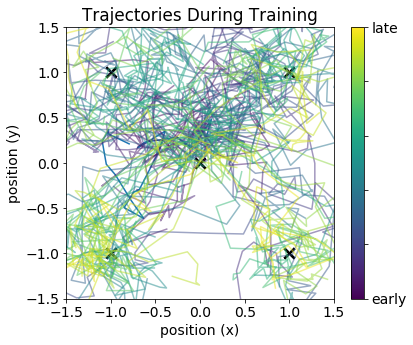

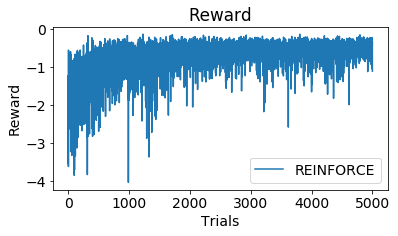

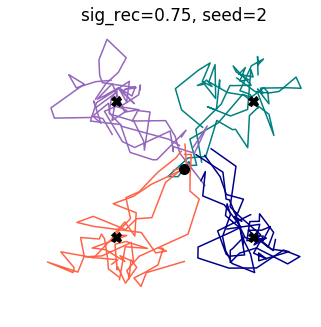

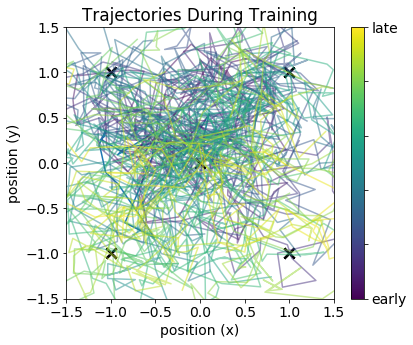

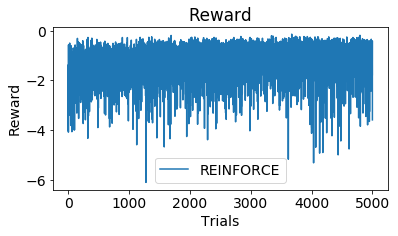

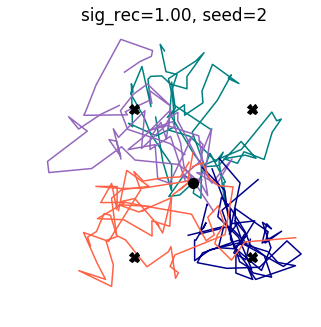

In [9]:
#noise = [0, 0.1,0.25,0.5, 1] #,1]

#noise = [0.01, 0.1,0.25,0.5]
trials0=500
trials1=5000
trials2=500
trials3=1000

sig_w_m=0.25
sig_rec = 0.25 
sig_out=0.01
noise = [0.25,0.5,0.75, 1] 
#neurons = [50,100,150,200]
n_rec = 50

""" Average over multiple seeds """
seeds = [0,1,2]#,1,2,3]

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corrcoef_list = []

    #for sig_out in noise:
    for sig_rec in noise:

        # Set RNN Parameters
        params = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=5,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                       sig_in=0.01,sig_rec=sig_rec,sig_out=sig_out,
                       velocity_transform=False,
                       rng=np.random.RandomState(seed))

        params.print_params()

        # Initialize RNN
        net0 = RNN(params)
        # set w_m matrix (with noise)
        w_m = np.copy(net0.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1])  # << keep random value constant, SHOULD NORMALIZE HERE

        corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
        print('corr coef:{:.3f}'.format(corrcoef))
        corrcoef_list.append(corrcoef)
        net0.set_weights(w_m = w_m)

        # initialize simulation
        sim0 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim0.run_session(n_trials=trials0, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)

        sim1 = Simulation(net0)
        """ RFLO """
        #rflo = RFLO(net0,apply_to=['w_rec']) 
        #sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=False, plot_freq=10)

    #     """ BPTT """
    #     bptt = BPTT(net0,apply_to=['w_rec']) # weight transport only applies when w_out is being learned
    #     sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

        """ REINFORCE """
        reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned
        sim1.run_session(n_trials=trials1, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=50)

        fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='sig_rec={:.2f}, seed={}'.format(sig_rec,seed))


        sim2 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim2.run_session(n_trials=trials2, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)




        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim0.session_probes['h'])
        F_late, score_late = flow_field_data(sim2.session_probes['h'])

        print('early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        Fpred_w_out = flow_field_predicted(net0.w_out,sim1.session_probes['err'],sim1.session_probes['h'])
        Fpred_w_m = flow_field_predicted(net0.w_m.T,sim1.session_probes['err'],sim1.session_probes['h'])


        """ Test """
        # Should this be a different network?
    #     sim_test = Simulation(net0)
    #     trackvars = TrackVars(net0,apply_to=[]) 
    #     sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=True, plot_freq=10)

        """ Test """
        # Should this be a different network?
        # Set RNN Parameters
        params_test = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=8,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
                       sig_in=0.0,sig_rec=0.5,sig_out=0.1, sig_fb=0.0,
                       velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
                       driving_feedback=False,
                       rng=np.random.RandomState(seed+10)) # note different seed
        #params_test.print_params()

        # Initialize RNN to sample new points in neural activity space
        net_test = RNN(params_test)
        net_test.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_out=np.copy(net0.w_out),w_m=np.copy(net0.w_m))

        sim_test = Simulation(net_test)
        trackvars = TrackVars(net_test,apply_to=[]) 
        sim_test.run_session(n_trials=trials3, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)


        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_m,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr2_list.append(corr2)
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corrcoef'].append(corrcoef_list)

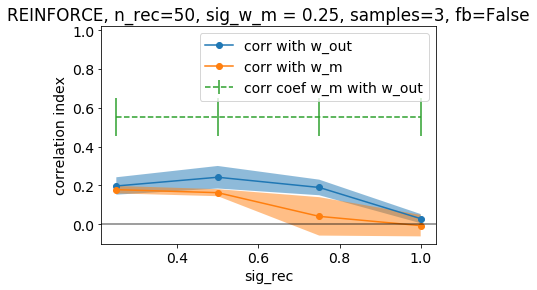

In [12]:
""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)

plt.plot(noise,mn1,'o-',label='corr with w_out')
plt.fill_between(noise,mn1-std1,mn1+std1,alpha=0.5)
plt.plot(noise,mn2,'o-',label='corr with w_m')
plt.fill_between(noise,mn2-std2,mn2+std2,alpha=0.5)

# readout alignment
mn3 = np.mean(np.asarray(stats['corrcoef']),axis=0)
std3 = np.std(np.asarray(stats['corrcoef']),axis=0)
#plt.plot(neurons,mn3,'x--',label='corr coef w_m with w_out')
plt.errorbar(noise,mn3,yerr=std3,label='corr coef w_m with w_out',linestyle='--')

plt.axhline(0,color='k',alpha=0.5)

plt.xlabel('sig_rec')
#plt.xlabel('sig_out')
#plt.xlabel('sig_w_m')
#plt.xlabel('number of recurrent units')
plt.ylabel('correlation index')
plt.ylim([-0.1,1.02])
plt.title('REINFORCE, n_rec={}, sig_w_m = {}, samples={}, fb={}'.format(n_rec,sig_w_m,len(stats['corr1']),net0.driving_feedback))
plt.legend()
plt.show()

# Experiment 2B - Vary number of recurrent units

For the same parameters, it is harder to learn using REINFORCE _with more units_

82it [00:00, 817.53it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.5
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f843daa86c0>
corr coef:0.415


500it [00:00, 779.51it/s]
5000it [00:11, 446.41it/s]
500it [00:00, 1271.16it/s]


early fit 0.909, late fit 0.945


1000it [00:00, 1379.24it/s]
95it [00:00, 937.72it/s]

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.5
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f842756a990>
corr coef:0.193


500it [00:00, 1055.04it/s]
5000it [00:18, 266.34it/s]
500it [00:00, 834.40it/s]


early fit 0.907, late fit 0.931


1000it [00:00, 1071.44it/s]
81it [00:00, 803.59it/s]

n_in: 4
n_rec: 150
n_out: 2
sig_in: 0.01
sig_rec: 0.5
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f84275dc288>
corr coef:0.157


500it [00:00, 932.85it/s]
5000it [00:32, 155.81it/s]
500it [00:00, 894.05it/s]


early fit 0.903, late fit 0.896


1000it [00:01, 898.81it/s]
83it [00:00, 827.55it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.01
sig_rec: 0.5
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7f841564b798>
corr coef:0.199


500it [00:00, 871.79it/s]
5000it [00:38, 128.78it/s]
500it [00:00, 635.74it/s]


early fit 0.918, late fit 0.917


1000it [00:01, 647.99it/s]


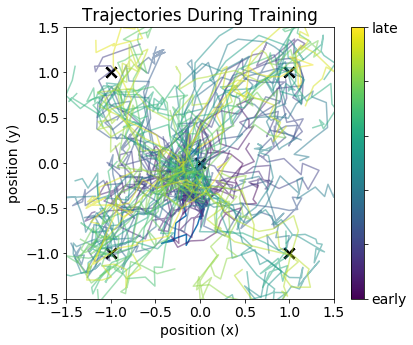

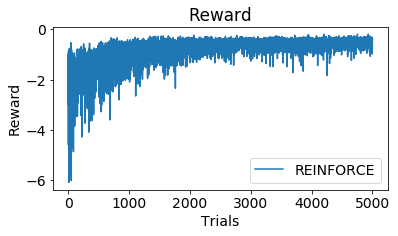

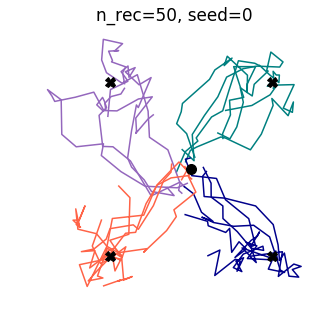

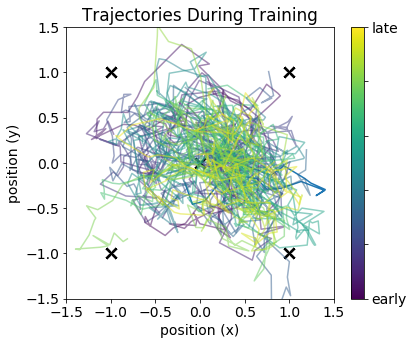

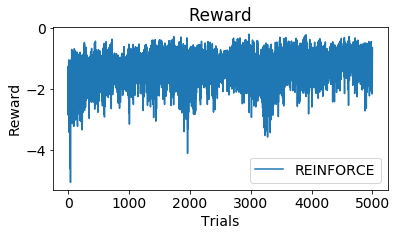

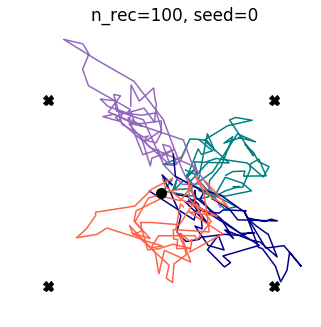

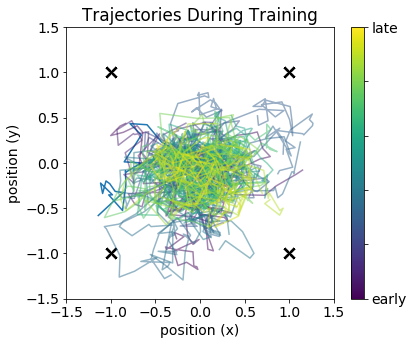

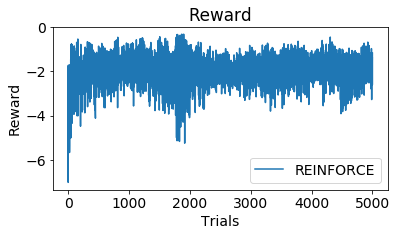

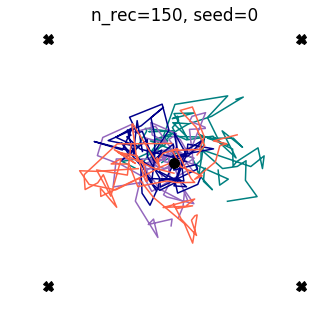

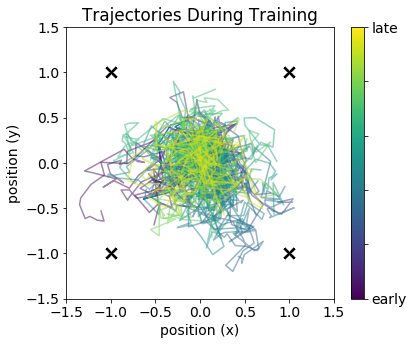

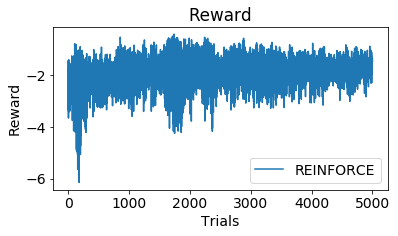

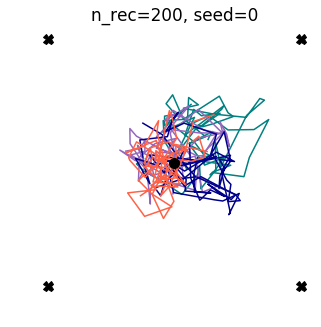

In [7]:
#noise = [0, 0.1,0.25,0.5, 1] #,1]

#noise = [0.01, 0.1,0.25,0.5]
trials0=500
trials1=5000
trials2=500
trials3=1000

sig_w_m=0.5
sig_rec = 0.5 
sig_out=0.01
noise = [0.25,0.5,0.75, 1] 
neurons = [50,100,150,200]
#n_rec = 50

""" Average over multiple seeds """
seeds = [0]#,1,2]#,1,2,3]

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corrcoef_list = []

    #for sig_out in noise:
    for n_rec in neurons:

        # Set RNN Parameters
        params = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=5,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                       sig_in=0.01,sig_rec=sig_rec,sig_out=sig_out,
                       velocity_transform=False,
                       rng=np.random.RandomState(seed))

        params.print_params()

        # Initialize RNN
        net0 = RNN(params)
        # set w_m matrix (with noise)
        w_m = np.copy(net0.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1])  # << keep random value constant, SHOULD NORMALIZE HERE

        corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
        print('corr coef:{:.3f}'.format(corrcoef))
        corrcoef_list.append(corrcoef)
        net0.set_weights(w_m = w_m)

        # initialize simulation
        sim0 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim0.run_session(n_trials=trials0, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)

        sim1 = Simulation(net0)
        """ RFLO """
        #rflo = RFLO(net0,apply_to=['w_rec']) 
        #sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=False, plot_freq=10)

    #     """ BPTT """
    #     bptt = BPTT(net0,apply_to=['w_rec']) # weight transport only applies when w_out is being learned
    #     sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

        """ REINFORCE """
        reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned
        sim1.run_session(n_trials=trials1, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=50)

        fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='n_rec={}, seed={}'.format(n_rec,seed))


        sim2 = Simulation(net0)
        trackvars = TrackVars(net0,apply_to=[]) 
        #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

        sim2.run_session(n_trials=trials2, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)




        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim0.session_probes['h'])
        F_late, score_late = flow_field_data(sim2.session_probes['h'])

        print('early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        Fpred_w_out = flow_field_predicted(net0.w_out,sim1.session_probes['err'],sim1.session_probes['h'])
        Fpred_w_m = flow_field_predicted(net0.w_m.T,sim1.session_probes['err'],sim1.session_probes['h'])


        """ Test """
        # Should this be a different network?
    #     sim_test = Simulation(net0)
    #     trackvars = TrackVars(net0,apply_to=[]) 
    #     sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=True, plot_freq=10)

        """ Test """
        # Should this be a different network?
        # Set RNN Parameters
        params_test = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=8,
                       eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
                       sig_in=0.0,sig_rec=0.5,sig_out=0.1, sig_fb=0.0,
                       velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
                       driving_feedback=False,
                       rng=np.random.RandomState(seed+10)) # note different seed
        #params_test.print_params()

        # Initialize RNN to sample new points in neural activity space
        net_test = RNN(params_test)
        net_test.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_out=np.copy(net0.w_out),w_m=np.copy(net0.w_m))

        sim_test = Simulation(net_test)
        trackvars = TrackVars(net_test,apply_to=[]) 
        sim_test.run_session(n_trials=trials3, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)


        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_m,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
        corr2_list.append(corr2)
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corrcoef'].append(corrcoef_list)

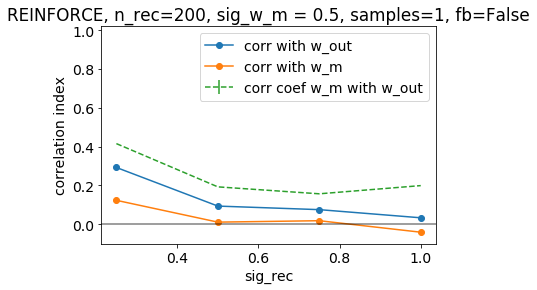

In [8]:
""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)

plt.plot(noise,mn1,'o-',label='corr with w_out')
plt.fill_between(noise,mn1-std1,mn1+std1,alpha=0.5)
plt.plot(noise,mn2,'o-',label='corr with w_m')
plt.fill_between(noise,mn2-std2,mn2+std2,alpha=0.5)

# readout alignment
mn3 = np.mean(np.asarray(stats['corrcoef']),axis=0)
std3 = np.std(np.asarray(stats['corrcoef']),axis=0)
#plt.plot(neurons,mn3,'x--',label='corr coef w_m with w_out')
plt.errorbar(noise,mn3,yerr=std3,label='corr coef w_m with w_out',linestyle='--')

plt.axhline(0,color='k',alpha=0.5)

plt.xlabel('sig_rec')
#plt.xlabel('sig_out')
#plt.xlabel('sig_w_m')
#plt.xlabel('number of recurrent units')
plt.ylabel('correlation index')
plt.ylim([-0.1,1.02])
plt.title('REINFORCE, n_rec={}, sig_w_m = {}, samples={}, fb={}'.format(n_rec,sig_w_m,len(stats['corr1']),net0.driving_feedback))
plt.legend()
plt.show()

In [ ]:
#noise = [0, 0.1,0.25,0.5, 1] #,1]

noise = [0.01, 0.1,0.25,0.5]

sig_w_m=0.5

corr1_list = []
corr2_list = []
corrcoef_list = []

for sig_out in noise:

    # Set RNN Parameters
    params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
                   eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                   sig_in=0.01,sig_rec=0.5,sig_out=sig_out,
                   velocity_transform=False,
                   rng=np.random.RandomState(1))
    params.print_params()

    # Initialize RNN
    net0 = RNN(params)
    # set w_m matrix (with noise)
    w_m = np.copy(net0.w_out.T) + sig_w_m*net0.rng.randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1])
    
    corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
    print('corr coef:{:.3f}'.format(corrcoef))
    corrcoef_list.append(corrcoef)
    net0.set_weights(w_m = w_m)

    # initialize simulation
    sim0 = Simulation(net0)
    trackvars = TrackVars(net0,apply_to=[]) 
    #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

    sim0.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)

    sim1 = Simulation(net0)
    """ RFLO """
#     rflo = RFLO(net0,apply_to=['w_rec']) 
#     sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

#     """ BPTT """
#     bptt = BPTT(net0,apply_to=['w_rec']) # weight transport only applies when w_out is being learned
#     sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)
    
    """ REINFORCE """
    reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned
    sim1.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=50)
    
    fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])

    
    sim2 = Simulation(net0)
    trackvars = TrackVars(net0,apply_to=[]) 
    #reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned

    sim2.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)




    """ Calculate F fields """
    F_early, score_early = flow_field_data(sim0.session_probes['h'])
    F_late, score_late = flow_field_data(sim2.session_probes['h'])
    
    print('early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

    Fdata = F_late - F_early

    Fpred_w_out = flow_field_predicted(net0.w_out,sim1.session_probes['err'],sim1.session_probes['h'])
    Fpred_w_m = flow_field_predicted(net0.w_m.T,sim1.session_probes['err'],sim1.session_probes['h'])


    """ Test """
    # Should this be a different network?
#     sim_test = Simulation(net0)
#     trackvars = TrackVars(net0,apply_to=[]) 
#     sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=True, plot_freq=10)

    """ Test """
    # Should this be a different network?
    # Set RNN Parameters
    params_test = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=8,
                   eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
                   sig_in=0.0,sig_rec=0.5,sig_out=0.1, sig_fb=0.0,
                   velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
                   driving_feedback=False,
                   rng=np.random.RandomState(27)) # note different seed
    #params_test.print_params()

    # Initialize RNN to sample new points in neural activity space
    net_test = RNN(params_test)
    net_test.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_out=np.copy(net0.w_out),w_m=np.copy(net0.w_m))

    sim_test = Simulation(net_test)
    trackvars = TrackVars(net_test,apply_to=[]) 
    sim_test.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h'], plot=False, plot_freq=10)


    corr1 = calculate_correlation(Fpred_w_out,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
    corr1_list.append(corr1)
    
    corr2 = calculate_correlation(Fpred_w_m,Fdata,sim_test.session_probes['h']) # sample different points in neural activity space
    corr2_list.append(corr2)

In [ ]:
plt.plot(noise,corr1_list,'o-',label='corr with w_out')
plt.plot(noise,corr2_list,'o-',label='corr with w_m')
plt.plot(noise,corrcoef_list,'x--',label='corr coef w_m with w_out')
plt.axhline(0,color='k',alpha=0.5)

plt.xlabel('sig_out')
#plt.xlabel('sig_out')
#plt.xlabel('sig_w_m')
plt.ylabel('correlation')
plt.ylim([-0.1,1])
plt.title('REINFORCE')
plt.legend()
plt.show()

5000it [00:08, 573.59it/s]


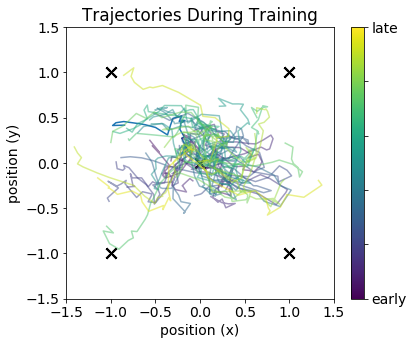

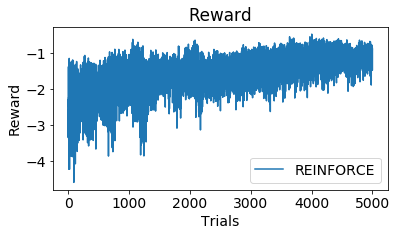

In [15]:
# Set RNN Parameters
# eta rec 0.1, 0.025
#sig_rec 0.1, 0.05
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.01,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False,
               rng=np.random.RandomState(1))

# Initialize RNN
net = RNN(params)


# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5) 
#rflo = RFLO(net,apply_to=['w_in','w_rec','w_out'],online=True) 

#sim.run_session(n_trials=10, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['pos','loss'], plot=True, plot_freq=1)

sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=100)


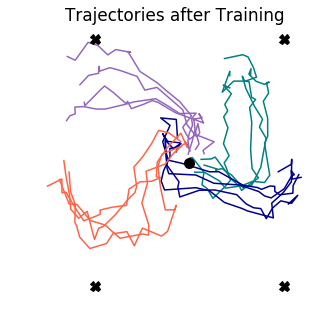

In [16]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])


## Testbed for Correlation Functions

Note that these functions are now in `rnn-learning/utils/metric.py`

## Test correlation across noise